In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
# Here perform one analysis based on the best CV
# Load dataset from npz files
dict_X = np.load('../dataset/X.npz')
dict_y = np.load('../dataset/y.npz')
# Store arrays from dictionary
X = dict_X['arr_0']
y = dict_y['arr_0']

In [3]:
# data split training/test sets for cross-validations
cv_splits = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

In [4]:
# pipeline of PCA and SVM for cross-validation over different training/test samples

# initialize PCA with n_components
n_PCA = 50
pca = PCA(n_components=n_PCA, whiten=True, svd_solver='randomized', random_state=42)
# initialize SVM with Radial Basis Functions (rbf) and balanced weights (although dataset is pretty balanced)
# parameters C and gamma are taken from previous analysis:
# {'svc__C': 10000.0, 'svc__gamma': 0.004}
sv_clf = SVC(kernel='rbf', class_weight='balanced', C=1e4, gamma=0.004)
model = make_pipeline(pca, sv_clf)

In [5]:
# cross-validation over train/test samples with PCA transformation into SVM classifier
%time cv_pca_50_svm = cross_val_score(model, X, y, cv=cv_splits)

Wall time: 30.4 s


In [6]:
cv_pca_50_svm

array([0.9089404 , 0.89403974, 0.92218543, 0.91059603, 0.88410596])

In [9]:
# Final results!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=42, svd_solver='randomized', tol=0.0,
                     whiten=True)),
                ('svc',
                 SVC(C=10000.0, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.004,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [33]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred,normalize='true')
np.diag(cm).min()

0.6875

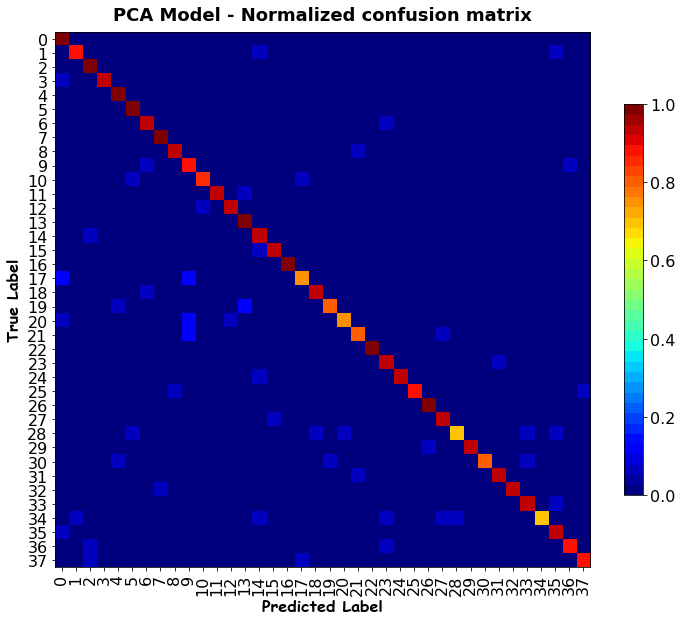

In [96]:
# Plot normalized confusion matrix
fig = plt.figure(figsize=[12,12])
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
disp = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.get_cmap('jet', 38),normalize='true',ax=ax1,include_values=False)
disp.ax_.set_title('PCA Model - Normalized confusion matrix', size=18, weight='bold',y=1.01)
label_prop = {'size':16,'weight':'bold','family':'fantasy'}
disp.ax_.set_xlabel('Predicted Label',fontdict=label_prop)
disp.ax_.set_ylabel('True Label',fontdict=label_prop)

xylabels = np.arange(0,38,1)
disp.ax_.set_yticks(xylabels)
disp.ax_.tick_params(axis='y', labelsize=16)
disp.ax_.set_xticks(xylabels)
disp.ax_.tick_params(axis='x', labelsize=16,rotation=90)

ax1.images[-1].colorbar.remove()
cbar = plt.colorbar(disp.im_, shrink=0.6)
cbar.ax.tick_params(labelsize=16)

# fig.savefig('../images/conf_mat_pca.png',dpi=800,bbox_inches='tight')


In [90]:
# print(classification_report(y_test, y_pred))

In [89]:
df_results = pd.DataFrame.from_dict(classification_report(y_test, y_pred,output_dict=True)).T
df_results.drop(['accuracy','macro avg','weighted avg'], axis=0,inplace=True)
df_results.drop(['support'], axis=1,inplace=True)

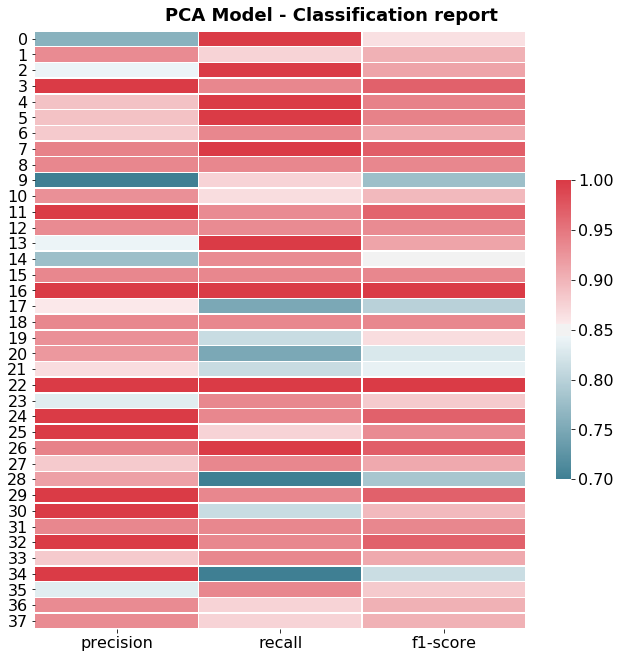

In [99]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

f.suptitle('PCA Model - Classification report', size=18, weight='bold',y=0.91)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(df_results, cmap=cmap, vmin=0.7, vmax=1, center=0.85,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16,rotation=0)
# use matplotlib.colorbar.Colorbar object
cbar = g.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=16)

f.savefig('../images/class_rep_pca.png',dpi=800,bbox_inches='tight')


In [7]:
# pca_sv_clf = GridSearchCV(model, param_grid = sv_grid, cv = cv_splits)